# Sentiment Polarity Prediction Introduction

This notebook experiments with various implementations of document-level sentiment analysis for movie reviews. The goal of the designed sentiment analysis model is to classify a movie review as either positive or negative.

Code for a classification system which uses Multinomial Naive Bayes was provided as a baseline model for this assignment. I took the code for this model, refactored it, expanded it and have implemented a more stream lined version of this code. I have also incorporated experimentation with different learning algorithms, model parameters and feature sets to improve on the accuracy scored by the baseline model.

All of the models in this notebook are trained on the movie review polarity data of Pang and Lee 2004 [A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization Based on Minimum Cuts](https://www.aclweb.org/anthology/P04-1035/). The dataset used in this paper is  available at http://www.cs.cornell.edu/People/pabo/movie-review-data (section "Sentiment polarity datasets") and contains 1000 positive and 1000 negative reviews, with each review being tokenised, sentence-split (one sentence per line) and lowercased.

In this dataset, each review has been assigned to 1 of 10 cross-validation folds by the authors. In order to compare our results with the published results, this is the setup I follow in this notebook. The models are evaluated and compared using an average of the 10-fold cross-validation accuracy scores.

During this process, no special treatment is given to rare or unknown words. Unknown words in the test data are skipped.

# -----------------------------------------------------------------------------------------------------------------

# Setup

### Packages neded to install

In order to be able to re-implement this work, there are a number of packages you will need to install. The commands for these are as follows:
- conda install numpy
- conda install pandas
- conda install tabulate
- conda install matplotlib
- conda install selenium
- conda install tqdm
- conda install scikit-learn (version > 0.24.0)
- conda install spacy
- conda install nltk
    - import nltk
    - nltk.download('opinion_lexicon')

### Import packages

In [1]:
# general packages
import os
import time
import pandas as pd
from tqdm.auto import tqdm
import numpy as np

In [2]:
# models needed for modelling
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

### Import the classes and functions from the '.py' file

Instead of having this notebook full of different functions with different applications, I decided to extract these from the notebook and to put them into a '.py' file. I could then read these functions in from the '.py' file without any problem which would enable me to keep this notebook compact and streamlined. The functions themselves are then easily accessible and readable from the '.py' file.

In [3]:
%load_ext autoreload
%autoreload 1
%aimport Sentiment_classification_functions

import Sentiment_classification_functions as scf

### Increase the width of this jupyter notebook to make room for the plots

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

### Increase the maximum number of rows displayed in this notebook

In [5]:
pd.set_option("display.max_rows", 100)

### Define the location of the chromedriver

In this code, I make use of a chromedriver to download the data from the internet. This is only done if the data is not already in your local folder. If you have cloned my original repo then the data will already be in the right place - in the 'Data' folder.

In [6]:
chromedriver_location = 'chromedriver.exe'

### Define the location of the data folder

In [7]:
data_directory = "Data"

# -----------------------------------------------------------------------------------------------------------------

# Load in the data

In starting this assignment, the first thing that needed to be done was I needed to go through the initially provided code and gain an understanding of it. When I did this, I realised how unnecessarily long and complex it was. My first job was to  simplify this code down to make it more understandable.

The first job in this was to remove the classes that were used in the original. I felt that all of the classes for reading in the data could be simplified down into one function called *'load_data'*. This function encapsulated the same functionality as the classes in the original code, which is:
1. Read in all the files in the data
    - If you have the data already downloaded then this data will be read in.
    - If you don't have the data already downloaded, the data will be downloaded from the web, put into the specified data folder, and then read in.
2. Turn this data into a map of cross validation folds and class labels to their associated documents.

I found this more simplistic approach worked well and condensed a lot of code and classes down into one function. The resulting output is a dictionary in the following format:

    {(cross validation fold 1, 'pos'): [[list of sentences in doc1], [list of sentences in doc2], ...],
     (cross validation fold 1, 'neg'): [[list of sentences in doc1], [list of sentences in doc2], ...],
     .................................................................................................
     (cross validation fold 10, 'pos'): [[list of sentences in doc1], [list of sentences in doc2], ...],
     (cross validation fold 10, 'neg'): [[list of sentences in doc1], [list of sentences in doc2], ...],
    }
This dictionary has two enteries for each cross validation fold, one for the positive documents and one for the negative documents. Each value in the dictionary then contains a list of documents associated with that cross validation fold and class label pair. Each document in this list is made up of a list of sentences with each sentence, in turn, being made up of a list of tokens.

### Load in the original data

This data file contains the original data that was used in the provided baseline model. While I wanted to change the input data to experiment with different features, I did not change this file for the purpose of being able to re-create the exact same results as the baseline model. I will instead use this original file to create the features I am looking for.

In [8]:
original_data_dict = scf.load_data(data_directory, chromedriver_location)

##### Preview the documents in this data

We can have a look at a preview of each document that falls under a specified fold & labal pair. The below preview table details the number of documents associated with the specified fold & label pair, the number of sentences in each of these documents, and then the first *'n'* characters in this document. This *'n'* value can be changed to display any amount of characters desired.

In [9]:
for label in ['pos', 'neg']:
    print('\n====', label, '====')
    docs_preview = scf.preview_docs_with_fold_label_pair(original_data_dict, fold=0, label=label, max_length=50, sep=" ")
    print(docs_preview.to_markdown())


==== pos ====
|    |   doc_num |   sentences | start_of_first_sentence                            |
|---:|----------:|------------:|:---------------------------------------------------|
|  0 |         0 |          25 | films adapted from comic books have had plenty of  |
|  1 |         1 |          39 | every now and then a movie comes along from a      |
|  2 |         2 |          19 | you've got mail works alot better than it deserves |
|  3 |         3 |          42 | " jaws " is a rare film that grabs your attention  |
|  4 |         4 |          25 | moviemaking is a lot like being the general        |
|  5 |         5 |          34 | on june 30 , 1960 , a self-taught , idealistic ,   |
|  6 |         6 |          31 | apparently , director tony kaye had a major battle |
|  7 |         7 |          32 | one of my colleagues was surprised when i told her |
|  8 |         8 |          14 | after bloody clashes and independence won ,        |
|  9 |         9 |          18 | the am

|    |   doc_num |   sentences | start_of_first_sentence                            |
|---:|----------:|------------:|:---------------------------------------------------|
|  0 |         0 |          35 | plot : two teen couples go to a church party ,     |
|  1 |         1 |          13 | the happy bastard's quick movie review damn that   |
|  2 |         2 |          23 | it is movies like these that make a jaded movie    |
|  3 |         3 |          19 | " quest for camelot " is warner bros . ' first     |
|  4 |         4 |          37 | synopsis : a mentally unstable man undergoing      |
|  5 |         5 |          35 | capsule : in 2176 on the planet mars police taking |
|  6 |         6 |          27 | so ask yourself what " 8mm " ( " eight millimeter  |
|  7 |         7 |          27 | that's exactly how long the movie felt to me .     |
|  8 |         8 |          33 | call it a road trip for the walking wounded .      |
|  9 |         9 |          49 | plot : a young french

### Create a lemmatised version of this data

Once I had the original data loaded, I could then work on using this to create different versions of this data that I could experiment with to try to improve the accuracy of the models. The first of these different versions I created was a lemmatised version of the data. I wanted to see whether lemmatising the words would enable me to better predict the class of a document. The process for creating this lemmatised version was to iterate through the fold-label pairs, the documents, and the sentences, and then to turn each token into a lemmatised version of itself. This was done with the help of the spacy package and its english language text processor which could easily identify the lemmatised version of each word.

* This creation takes about 4:20 mins locally & 3:20 mins using Google Colab Pro

In [ ]:
lem_data_dict = scf.lemmatise_the_data(original_data_dict)

  0%|          | 0/20 [00:00<?, ?it/s]

##### Preview the documents in this data

Again we can look at a preview of each document that falls under a specified fold & label pair. Here you can see in the document previews that the words have been changed - plural words have been changed to singular and different verb versions have been changed to their base form.

NOTE: Outside the lemmatisation, there is another slight difference between this data and the original data as the tokaniser used to create this lemmatised version is the native spacy tokaniser. This tokaniser is different to the one used in the original as it turns contractions, like "don't" or "I've" into two tokens ("do n't" & "I 've") as opposed to having these contractions being one word. While I don't think this difference will have a massive effect on the outcome, it is something to note as being different from the original alongside the lemmatisation.

In [ ]:
for label in ['pos', 'neg']:
    print('\n====', label, '====')
    docs_preview = scf.preview_docs_with_fold_label_pair(lem_data_dict, fold=0, label=label, max_length=50, sep=" ")
    print(docs_preview.to_markdown())

### Create a version of this data with negation handled in it

The next version of the original data that I wanted to create from the original data was one where negation was handled. This version would then be experimented with to see whether handling negation has an effect on the resulting accuracy scores.

While there are a number of ways negation can be handled, in this function, the negation is handled in a simple manner. Here if a negative word appears, like "*not*", "*no*" or a word ending in "*n't*", then the words that follow this word up until the next punctuation mark are changed to add "*NOT_*" as a prefix.

Eg. "The man didn't know how to speak, but he was fine." --> "The man didn't NOT_know NOT_how NOT_to NOT_speak, but he was fine."

In [ ]:
negated_data_dict = scf.handle_negation_in_the_data(original_data_dict)

##### Preview the documents in this data

The above logic is easy to see in the below previews where you can see *'NOT_'* has been added to words appearing after negative words.

NOTE: Unlike in the lemmatised data, the tokens here are the same as that used in the original data and contractions remain as one word.

In [ ]:
for label in ['pos', 'neg']:
    print('\n====', label, '====')
    docs_preview = scf.preview_docs_with_fold_label_pair(negated_data_dict, fold=0, label=label, max_length=50, sep=" ")
    print(docs_preview.to_markdown())

# -----------------------------------------------------------------------------------------------------------------

# Create training-test splits for Cross-Validation

This is where we split these datasets into train and test splits. There are 1000 positive documents and 1000 negative documents and we must split these 2000 documents into 10 different cross validation splits. This gives an 1800-200 train-test split for each of the 10 cross validation folds.

Each dataset created above contains exactly the same number of documents with each document being in the exact same order and having the same sentences within it. As a results, we can garentee that the sentences and documents in each cross validation set are the exact same across all of these datasets. This is important as it makes sure that the data we are testing on and comparing the models with is as close to the exact same as possible and that the only variable between them is the one change made to the dataset (lemmatisation, negation handling, or whatever it may be).

In [ ]:
org_train_test_splits = scf.get_train_test_splits(original_data_dict)
lem_train_test_splits = scf.get_train_test_splits(lem_data_dict)
neg_train_test_splits = scf.get_train_test_splits(negated_data_dict)

### Show the splits

We can visualise the number of documents in each cross validation fold. As discussed, this breakdown is the exact same across all datasets.

In [ ]:
scf.count_docs_in_train_test_split(org_train_test_splits)

# -----------------------------------------------------------------------------------------------------------------

# Experimentation & model evaluation

Once I had the data set up, the next step was to have a look at experimenting with:
1. different machine learning algorithms
2. different feature sets

When it came to experimenting with these different machine learning algorithms and feature sets, my intial thought process was to set up a pipeline that will iterate through every different combination of these values and evaluating a model for each of these combinations.

This would mean that for each selected dataset, I would have a multiple models with different learning algorithms, and then for each of these specified datasets and learning algorithms, I would have multiple models with different feature set values. This seemed like a good starting point for the experimentation as it would enable me to compare every single model directly to deduce the most accurate model.

### Choosing the models to experiment with

The first step in this process was to get the code to a point where I could specify which machine learning algorithm to use by means of a parameter. This would enable me then to iteratively pass new learning algorithms as a parameter when evaluating the models.

The initial baseline model was a *Multinomial Naive Bayes* model and was implemented as multiple classes. Similar to the way the initial code for loading in the data was, I found that the provided code for implementing this model was unneccessarily complex. I again set about refactoring and restrucuring this code to make it more readible and condensed. Once I had done this, I was left with a single model class that could be used to implement a model. I was able to set this class up with a class variable that could be used to specifying the machine learning algorithm used in this model.

The resulting setup meant that I could create a list of all of the learning algorihtms that I wanted to evaluate and then iteratively run through them, each time creating and instance of the model class specifying this learning algorithm as the model variable for that instance.

---

Through this experimentation, I attempted to evaluate a number of learning algorithms alongside the baseline model. The algorithms that I compared to the baseline *Multinomial Naive Bayes* algorithm are:
 - Logistic regression,
 - Decision trees,
 - Support vector machines,
 - Random Forest Classifiers,
 - Stochastic Gradient Descent Classifiers.
 
These models all have implementations in the scikit-learn package which meant they were relatively easy to implement. The default scikit-learn parameters for these models are as follows:
 - Multinomial Naive Bayes
    * sklearn.naive_bayes.MultinomialNB(*, alpha=1.0, fit_prior=True, class_prior=None)

 - Logistic Regression
    * sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
  
 - Stochastic Gradient Descent Classifier
    * sklearn.linear_model.SGDClassifier(loss='hinge', *, penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)

 - Random Forest Classifier
    * sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

 - Support Vector Machine
    * sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', break_ties=False, random_state=None)

 - Decision Trees
    * sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, ccp_alpha=0.0)
    
    
While it would be possible to further experiment with the parameters of these models, I decided to use the default parameters for the purpose of keeping the complexity of the evaluation process as simple as possible. Due to the fact that I am iterating through many other parameters and already experimenting with so many differently cofigurated models, using the defaults parameters in these models enabled me to not lose track of my experimentation.

---

Below is the dictionary used to iteratively evaluate these learning algorithms. This dictionary maps a string of the model name to the scikit-learn implementation of the model itself. Later in the process, this dictionary will be iterated through along with other parameters to create the model with specific parameters. These models will then be evaluated and output to a CSV file. The model name in this dictionary is needed as it helps keep track of the learning algorithm used in each model.

In [ ]:
model_dict = {"Multinomial Naive Bayes":  MultinomialNB(),
              "Support Vector Machine":   SVC(),
              "Random Forest Classifier": RandomForestClassifier(),
              "Logistic Regression":      LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500),
              "Stochastic Gradient Descent Classifier": SGDClassifier(),
              "Decision Tree":            DecisionTreeClassifier(),
             }

### Choose the feature sets to experiment with

The experimentation with different feature sets happens in a similar way as that described above with the models. We define a list/dictionary containing the feature sets we want to experiment with and then iterate through these lists/dictionaries, creating seperate models these diffferent feature sets that will then be evaluated to analyse the effect these differences had.

There are two different approaches I take to setting up these different feature sets.
1. Pre-processing the data and creating a new dataset that can be fed into the model for training and evaluation.
2. Passing a parameter to make the model handle the features differently when creating the model instance.

##### Pre-processed features

We saw earier in this notebook that I have created a number of different train-test split datasets that can be passed into the model. These are:
1. The original dataset.
2. A lemmatised version of the original dataset.
3. The original dataset with negation being handled in it.

Since these datasets are already created, it is as simple as creating a dictionary mapping a string that describes these datasets to the train-test split dataset itself. This can then be iterated through to train and evaluate the defined models on.

In [ ]:
data_dict = {"Original":   org_train_test_splits,
             "Lemmatised": lem_train_test_splits,
             "Negated":    neg_train_test_splits,
            }

##### Passing a parameter to enable the use of different features

The other option to experimenting with different feature sets is to pass a parameter when creating the model instance that will effect the feature sets used when training the model. I used this approach when I wanted to experiment with:
1. The ngram size
2. Whether the token counts should be clipped at '1' or not
3. Whether to add a sentiment lexicon feature to the data

As with the previous parameters that I wanted to experiment with, this meant that I would define a dictionary/list of the values to test for these parameters to enable me to iterate through these dictionaries/lists when defining the different models.

In [ ]:
ngram_size_dict = {"Unigram": 1,
                   "Bigram":  2,
                   "Trigram": 3,
                  }

clip_counts_vals = [True,
                    False
                   ]

sent_lex_vals = [True,
                 False
                ]

### Iterate through all the combinations of these parameters and define a model for each

This is where we now define the models.
As described above, I have defined a number of dictionaries and lists of the paramaters that I want to experiment with. The next stage is to define the model class instances with these parameters.

Here we take in these lists and iterate through each of them, each time defining a model. There are:
    
    (# learning algorithms) x (# pre-processed train-test datasets) x (# ngram sizes) x (# clip count values)
    
combinations of parameters to use to define the models. The list returned from the function below will contain, for each combination, a tuple of the models configuration parameters, the dataset to test this model on, and then the model class instance itself. Each item in this list will be iterated through one-by-one to evaluate the model on the specified train-test split within it.

In [ ]:
models_to_compare = scf.define_models_with_params(model_dict, data_dict, ngram_size_dict, clip_counts_vals, sent_lex_vals)

### Define the location where the results of the model evaluation are to be stored

To ensure that the results of each model is safe from any failure throughout the running process, I output the results of each model to a CSV as soon as it is finshed evaluating. The resulting evaluation CSV's are stored in the below directory: 

In [ ]:
model_eval_results_directory = os.path.join(data_directory, "Model_results")

### Train & test these models and then output their results to a CSV

While it would be ideal to define all the different combinations of these models and then run through each of these defined combinations evaluating each one, some of the models take a really long time to train due to their high RAM usage and they offer no improvement in accuracy score so they are inefficient to run. To get around this and to ensure I used my time efficiently, before running this model evaluation code, I selectively choose the parameters that I explicitely want to experiment with from the above defined lists. This enables me to leave out inefficient or useless combinations of parameters when defining the models.
The above defined lists & dictionaries have been set up to allow the values to easily be commented out. This would ensure they are not included in the combinations and in turn speed up the evaluation process as there are less models to evaluate.

The below function iteratively trains and evaluates these models, each time storing the results in a CSV so that they are not lost. The results can then be read back in from these CSV's for analysis and comparison.

---

The metric used to score the models in this classification task is "accuracy". Accuracy defines how many predictions the model got right and it measured by the following formula:

                          (# True Positives) + (# True Negatives)
    -------------------------------------------------------------------------------------
     (# True Positives) + (# False Positives) + (# True Negatives) + (# False Negatives)
     
While F1 is usually a better metric when scoring models in classification tasks as it emphasises true positives, when the classes are balanced like they are in this task, accuracy does the same job as F1 at scoring model accuracy. As a result, I chose to stick with accuracy as my evaluation metric just for simplicity.

In [21]:
error_names = []
for model_params, train_test_split_data, model in tqdm(models_to_compare):
    try:
        print("\n" + model_params["full_name"])
        # evaluate the model
        model_eval_df = scf.evaluate_model(model, model_params, train_test_split_data, fold_verbose=True, plot_folds=True)
        # save this models evalutaion scores to a CSV
        model_eval_df.to_csv(os.path.join(model_eval_results_directory, model_params["full_name"]+'.csv'), index=False)

    except KeyboardInterrupt:
        break
    except Exception as e:
        # this is in case of a RAM issue or other - to prevent the run crashing we just skip that model and move on
        print(e)
        error_names.append(model_params)

  0%|          | 0/216 [00:00<?, ?it/s]


Original Unigram Multinomial Naive Bayes (ClipCounts=True, SentLexFeature=True)
   Fold 1

In [22]:
error_names

[]

# -----------------------------------------------------------------------------------------------------------------

# Read in all tested  models

At this stage in the notebook, the models have all been trained, evaluated, and the results of their evaluation have been stored in a CSV. This next step reads in the results of all of the models and compiles a dataframe of these for each model. This dataframe will then be subset and analysed in the below detailed experimentation.

In [23]:
all_models_results = scf.read_in_all_model_evaluation_results(model_eval_results_directory)

A total of 91 models have been run.
The total time it took to evaluate these models was 42 hours.


The below is a full summary of the results of all the trained models across all of the parameters. The details and accuracy scores of these configured models will be broken down further in the experimentation in the next section.

In [24]:
all_models_results

,Full Name,Data Type,Model,Ngram,Clip Counts,Sentiment Lexicon Feature,Avg Accuracy,Accuracy Std Dev,Min Accuracy,Max Accuracy,Total Time (s),All Fold Averages
0,Lemmatised Bigram Multinomial Naive Bayes (Cli...,Lemmatised,Multinomial Naive Bayes,Bigram,False,False,0.8410,0.028089,0.775,0.870,853.54,"[0.775, 0.86, 0.83, 0.865, 0.81, 0.835, 0.855,..."
1,Lemmatised Bigram Multinomial Naive Bayes (Cli...,Lemmatised,Multinomial Naive Bayes,Bigram,True,False,0.8535,0.023243,0.805,0.885,843.02,"[0.805, 0.865, 0.84, 0.86, 0.825, 0.85, 0.86, ..."
2,Lemmatised Trigram Multinomial Naive Bayes (Cl...,Lemmatised,Multinomial Naive Bayes,Trigram,False,False,0.7815,0.012855,0.760,0.805,1422.81,"[0.79, 0.785, 0.775, 0.76, 0.78, 0.775, 0.785,..."
3,Lemmatised Trigram Multinomial Naive Bayes (Cl...,Lemmatised,Multinomial Naive Bayes,Trigram,True,False,0.7840,0.017000,0.755,0.820,1417.06,"[0.82, 0.795, 0.77, 0.755, 0.78, 0.785, 0.785,..."
4,Lemmatised Unigram Multinomial Naive Bayes (Cl...,Lemmatised,Multinomial Naive Bayes,Unigram,False,False,0.8110,0.024372,0.755,0.835,694.20,"[0.78, 0.825, 0.835, 0.82, 0.81, 0.805, 0.835,..."
5,Lemmatised Unigram Multinomial Naive Bayes (Cl...,Lemmatised,Multinomial Naive Bayes,Unigram,True,False,0.8225,0.019780,0.795,0.865,697.71,"[0.8, 0.835, 0.83, 0.81, 0.825, 0.805, 0.825, ..."
6,Lemmatised Bigram Random Forest Classifier (Cl...,Lemmatised,Random Forest Classifier,Bigram,False,False,0.7545,0.042098,0.685,0.810,516.63,"[0.795, 0.785, 0.72, 0.685, 0.71, 0.805, 0.81,..."
7,Lemmatised Bigram Random Forest Classifier (Cl...,Lemmatised,Random Forest Classifier,Bigram,True,False,0.7725,0.035725,0.740,0.840,498.50,"[0.765, 0.745, 0.75, 0.75, 0.74, 0.795, 0.835,..."
8,Lemmatised Unigram Random Forest Classifier (C...,Lemmatised,Random Forest Classifier,Unigram,False,False,0.7915,0.018715,0.760,0.820,103.42,"[0.785, 0.82, 0.76, 0.8, 0.775, 0.78, 0.815, 0..."
9,Lemmatised Unigram Random Forest Classifier (C...,Lemmatised,Random Forest Classifier,Unigram,True,False,0.7960,0.017146,0.765,0.820,102.63,"[0.79, 0.815, 0.82, 0.79, 0.77, 0.81, 0.8, 0.7..."


Having trained the models above and read all of their results into a dataframe, we can now use subsets of this dataframe to visuslise the effect that changing different parameters has had on the models accuracy. In the next section, we will dive into analysing these experiments and concluding the best parameter set for this given task.

# -----------------------------------------------------------------------------------------------------------------

# Experiments with the learning algorithms

In this first experiment, I attempt to explore the effect different learning algorithms have on the model's accuracy score compared to the baseline *Multinomial Naive Bayes* model. From the above compiled results table, the accuracy of this intial baseline sits at 81.65% as this is the score we must improve on.

To isolate the variables in this experiament, we will only look at the effect that these different learning algorithms had when tested on the original data, with unigram tokens as the features, without adding a sentiment lexicon feature to the data, and when the counts were not clipped at 1. This is the same setup as the original baseline model that was provided for this assignment so will enable us to really see whether we can improve on the original accuracy score by simply just changing the machine learning algorithm.

The first step to this experiment is subsetting the dataframe of all tested models to the specified parameters we want and then we can plot the accuracy scores of the models.

In [26]:
exp_1_models = all_models_results[(all_models_results["Data Type"] == "Original") & (all_models_results["Ngram"] == "Unigram") & (all_models_results["Clip Counts"] == False) & (all_models_results["Sentiment Lexicon Feature"] == False)]

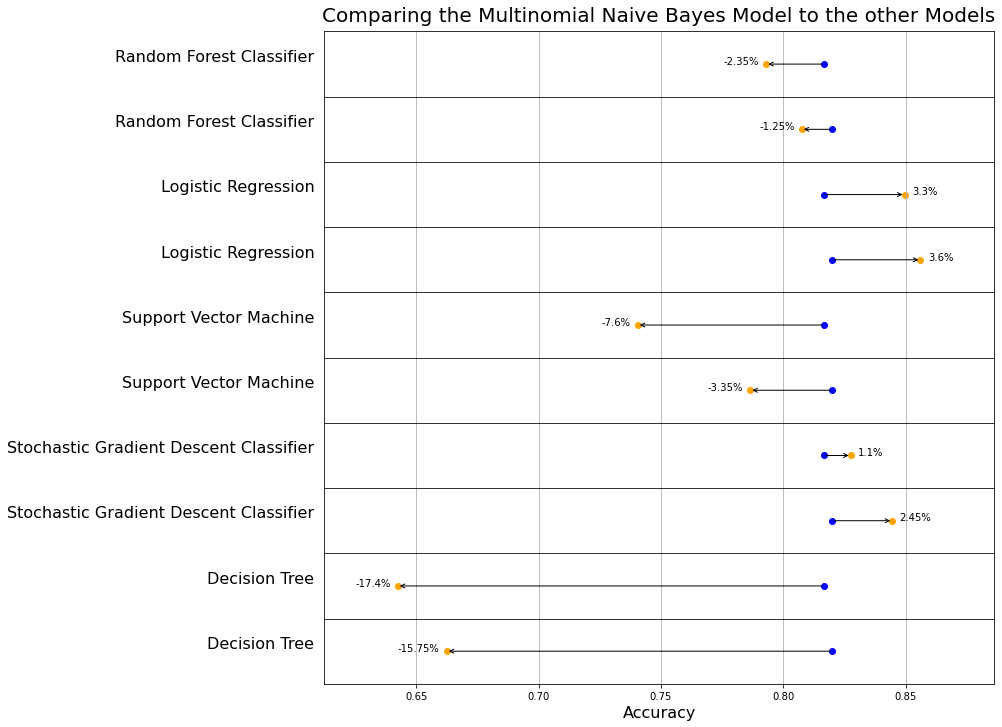

In [27]:
scf.compare_models_plot(exp_1_models, "Model", "Multinomial Naive Bayes")

As you can see from the above plots, the different algorithms have mixed results with 3 of them performing worse than the baseline and 2 of them performing better than the baseline.

While the Random Forest Classifier performed less than 3% worse, Support Vector machines were significantly worse with their average accuracy nearly 8% below the baseline. Despite this, Decision Trees performed extremely poorly in comparison with a 17% decrease in reported accuracy relative to the baseline Multinomial Naive Bayes model.

Of the models that performed better than the baseline, they still report an accuracy score that is quite close to the baseline accuracy with Stochastic Gradient Descent Classifiers performing just over 1% better and Logistic regression performing over 3% better.

Based solely on this experiment, which uses the same parameters as the baseline model did outside of the experimented learning algorithm, Logistic Regression is the best performing algorithm. This being said, I think the margins are relatively small and the only conclusion that I would be happy drawing from this experiment alone is that Decision Tree algorihtms are very poor performers at this sentiment classification task.

# -----------------------------------------------------------------------------------------------------------------

# Experiment with clipping the word counts

Since we have seen the effect changing the learning algorithm has had on the classification accuracy, we can now test the effect that clipping the word counts at '1' can have.

As in the previous experiment, the first step is to subset the dataframe containing all the tested models results to specify that the original dataset, unigram features, and no sentiment lexicon features are used in our experiment. Then I can create a plot of all of the learning algorithms without the word counts being clipped at '1' and then those same algorithms with the word counts clipped at '1'. This plot will enable us to actively compare the effects this clipping parameter has.

In [28]:
exp_2_models = all_models_results[(all_models_results["Data Type"] == "Original") & (all_models_results["Ngram"] == "Unigram") & (all_models_results["Sentiment Lexicon Feature"] == False)]

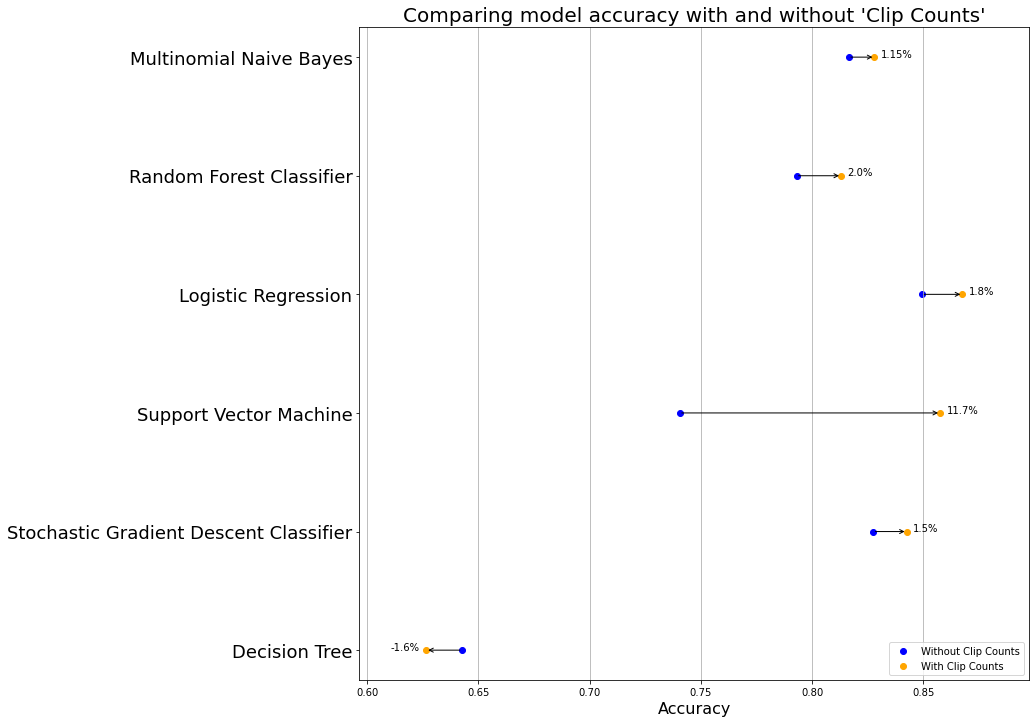

In [29]:
scf.compare_param_plot(exp_2_models, "Clip Counts", False, True)

This plot shows the baseline model that uses the Multinomial Naive Bayes algorithm in the top row and then the models that use the other learning algorithms underneath this.

The results of this plot clearly show that the majority of the algorihtms perform better when the word counts are clipped at 1.
This is the case with all of the models bar the Decision Tree model which was the worst performing model to begin with. Nevertheless, this decrease in performance makes sense under the Decision Tree model architechture as I would imagine it uses the word counts in one of its branches to distinguish between the classes.

The decision to clip the counts seemed particularly significant in the Support Vector Machine algorithm. This model got a boost of almost 12% by just clipping the word counts in the feature matrix at 1. This improvement was a clear outlier relative to the parameters effect on the other models, however, while this was a significant increase, as this model was previously the second worst performing model, as seen in the last experiment where it achieved an accuracy score almost 8% below the baseline, the increase in accuracy given to this algorithm by clipping these counts brought it up in line with the accuracy of the other models.

Of the other models, there seems to be a clear increase in performance of approximately 1.6%. This experiment clearly points to clipping the counts at 1 being the superior parameter choice unless using the Decision Tree algorithm. It seems unlikley that the Decision Tree algorithm would come out on top however, as based on this graph the Decision Tree algorithm performs nearly 20% below the other algorithms.

---

Not only does this plot allow us to see the effect that clipping the word count features has on these algorithms, it also allows us to re-compare the algorithms accuracy scores to one another. As a majority of the algorithms were improved by this word count clipping, we can take it that they are on a level playing field with regard to the parameter choice. By focusing on the yellow points for each model, we can see that with this parameter the Logistic Regression algorithm still performs the best out of all the learning algorithms, however, this time, with the boost this parameter gave to the the Support Vector Machine algorihtm, it is not far behind.
If this alone was the extent of the experamintation, we would have seen a 5.1% increase in the reported classification accuracy by choosing the Logistic Regression algorithm with the counts clipped.

# -----------------------------------------------------------------------------------------------------------------

# Experiment with the ngram size

The next step to this experimentation is to experiment with the ngram size of the features used in the model. This means that if we specify that we want to use bigram features, instead of each word being a feature in the feature matrix, each two word pair becomes a feature in the feature matrix.

This results in more feature combinations, which makes these bigram models take much longer to train and makes them usd up much more RAM in storing these token pairs as features. As my laptop only has 8gb of RAM, some of these models were particularly slow to the point where it was not feasible to run them. As I wanted to have thorough experimentation for this assignment, I purchased Google Colab Pro to give me access to their 27gb of RAM. This enabled me to run bigram and trigram versions of some of the more RAM hungry learning algorithms.

As the above experiment deduced that clipping the counts at 1 improved the accuracy scores of all the models bar the Decision Tree model, we will clip the counts in both sides of the comparison for this experiment. We will also continue using the original dataset used by the initial baseline model.

In [30]:
exp_3_models = all_models_results[(all_models_results["Data Type"] == "Original") & (all_models_results["Clip Counts"] == True) & (all_models_results["Sentiment Lexicon Feature"] == False)]

### How does using a bigram feature set effect the accuracy of the models?

First we will look at how these models are effected by using a bigram feature set as opposed to a unigram feature set. We will plot each model when using both of these and see the difference between their average accuracy values.

NOTE: The Support Vector Machine model is not in this plot as it takes 7 hours to run and when I went to run it on Google Colab Pro, I got 6 hours through and my internet dropped in turn dropping the Google Colab runtime. Nevertheless, I suspect that the results would be quite similar to that of the other models as when I ran the bigram Support Vector Machine on the original dataset without the word counts clipped, it got an accuracy score of 75% which was a decrease compared to the accuracy when using the unigram feature set.

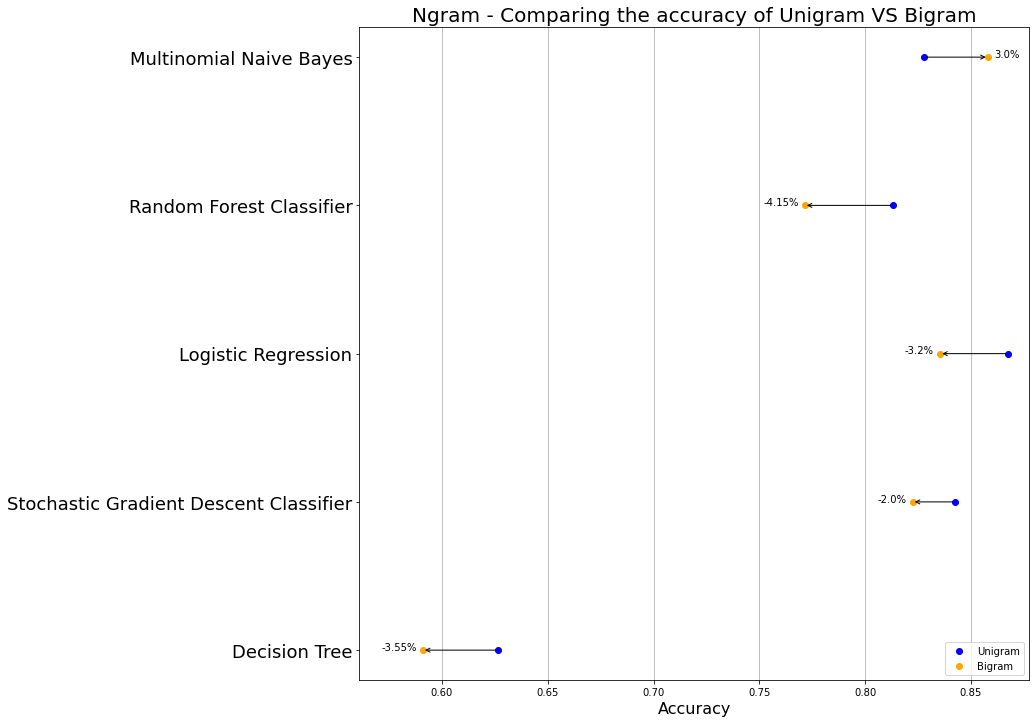

In [31]:
scf.compare_param_plot(exp_3_models, "Ngram", "Unigram", "Bigram")

As you can see, using a bigram feature set doesn't seem to help a whole lot outside of the baseline Multinomial Naive Bayes model, with each of the other models decreasing in accuracy by 2-4%. While the Logistic Regression algorithm had the highest accuracy on the unigram feature set, when both algorihtms used a bigram feature set, it was overtaken by the Multinomial Naive Bayes model which saw an increase in accuracy of 3%. However, despite this increase using the bigram feature set, the Multinomial Nave Bayes model did not improve enough to overtake the Logistic Regression algorithm when it is used on the unigram feature set. As a result, the unigram Logistic Regression model remains the most accurate model so far.

### How does using a trigram feature set effect the accuracy of the models?

We just saw the effect that the increase from unigram feature sets to bigram feature sets has had on the models and for the most part this was not good but as the Multinomial Naive Bayes model produced a promising increase, I wanted to see how the models would fair using a trigram feature set. In this plot, we will compare the difference between the models on unigram feature sets and the models on trigram feature sets.

Some learning algorithms were too computationally expensive and slow to run using the trigram feature sets so as a result I left these out. Despite this, I don't think the conclusion for this experiment was effected by this.

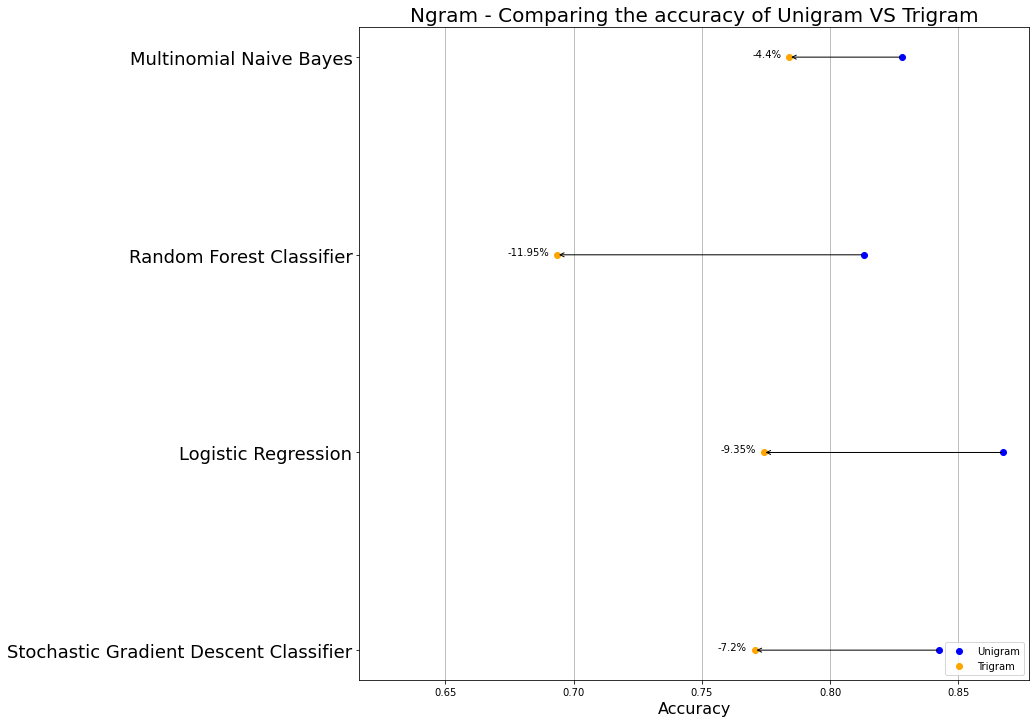

In [32]:
scf.compare_param_plot(exp_3_models, "Ngram", "Unigram", "Trigram")

Again here as you can see, trigram feature sets do nothing to improve the accuracy of the models. Even in the case of the Multinomial Naive Bayes model which saw an increase in accuracy when using the bigram feature set, the trigram feature set achieved an accuracy score almost 4.5% below the models accuracy on the unigram feature set.

In comparison to the effect using a bigram feature set had on the other models, the trigram feature set saw an even more significant decrease in accuracy score when compared to the accuracy when using the unigram feature set.

---

As a result of this, we can conclude that the larger ngram size has not had a positive effect on these models. From looking at the effects of the bigram and the trigram feature sets, we could even take this conclusion further and say the more we increase the bigram size, the worse the results become. Due to my findings in this experiment, I do not think it is worth attempting these models on ngram sizes any higher as I do not think this will have a positive effect on the model accuracies. For every model except the Multinomial Naive Bayes model, the best feature set to use is the unigram feature set.

# -----------------------------------------------------------------------------------------------------------------

# Experiments with the data used to train the models

In this next experiment, we will explore the effects that the different data sets had on the models accuracy scores. In the above code, we created two variations of the original data, a lemmatised version and a negation handled version. Here we will attampt to visualise the effect these different datasets had.

As concluded in the previous two experiments, clipping the word counts at 1 and using a unigram feature set seems to achieve the best accuracy combination. Of all the models tested so far, we saw the highest accuracy score achieved in the Logistic Regression model when using these parameters. As a result, this is how we will restrict this experiment to ensure there is only one variable across the models. We will also continue to not add the sentiment lexicon feature as this will be experimented with in the next experiment.

In [33]:
exp_4_models = all_models_results[(all_models_results["Clip Counts"] == True) & (all_models_results["Ngram"] == "Unigram") & (all_models_results["Sentiment Lexicon Feature"] == False)]

### How does lemmatising the data effect the accuracy of the models?

The first of the two versions of the original dataset that we will compare is the lemmatised version. As above when comparing the unigram feature sets to the bigram feature sets, we will create a plot with the blue dots showing the original and the yellow dots showing the accuracy score after the change was done to the model. This allows us to easily compare the effect this change had.

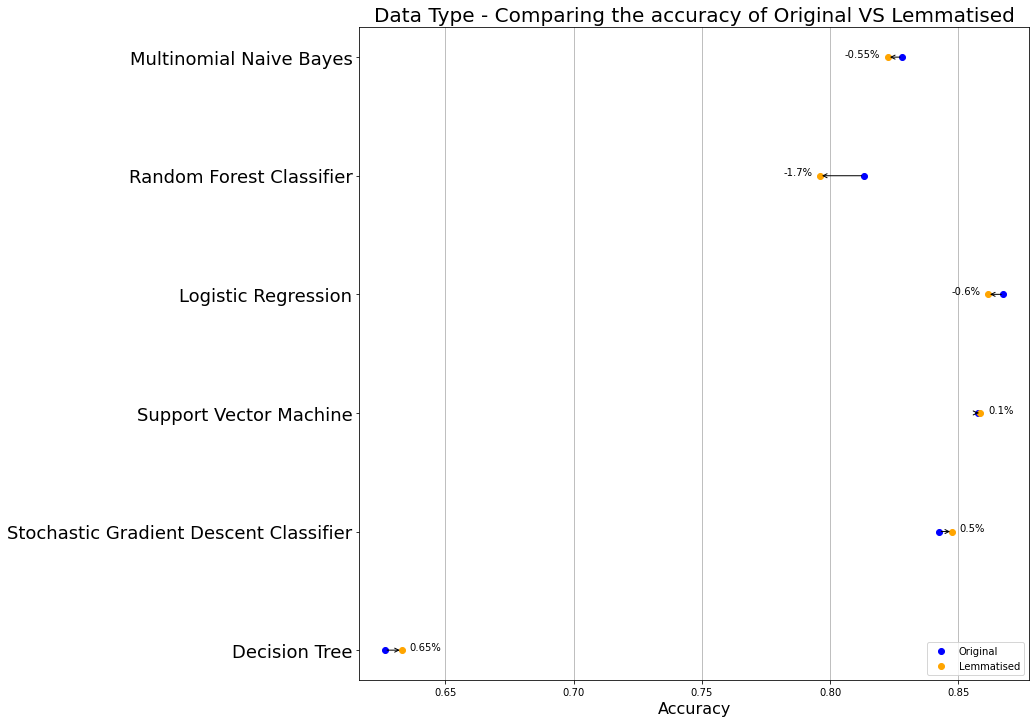

In [34]:
scf.compare_param_plot(exp_4_models, "Data Type", "Original", "Lemmatised")

As you can see the effect that this change has had is minimal with the average absolute change being only 0.7%. Despite the small absolute chage, this change had a positive effect on 3 of these models and a negative effect on the other 3 models with the average change across all the models being -0.3%. This points to lemmatising the data as having a negative effect on the models. This is evident in the Logistic Regression model which was the best performing model with an accuracy of 86.75% (see above table for specific accuracy scores) where this model decreased in accuracy by 0.6%. While it still remained the best performing algorithm of all the models, the effect lemmatisation had was not good and as a result should not be used when selecting a final model with the best parameters.

### How does negation handling on the data effect the accuracy of the models?

While lemmatisation was not useful as far as improving the best models accuracy goes, we will now look at whether negation can help with this. As discussed above, the negation handled dataset adds "NOT_" as a prefix to all words that appear in a sentence after a negative word up until the next punctuation mark in the sentence. The below plot will show us the effect this simple handling has had.

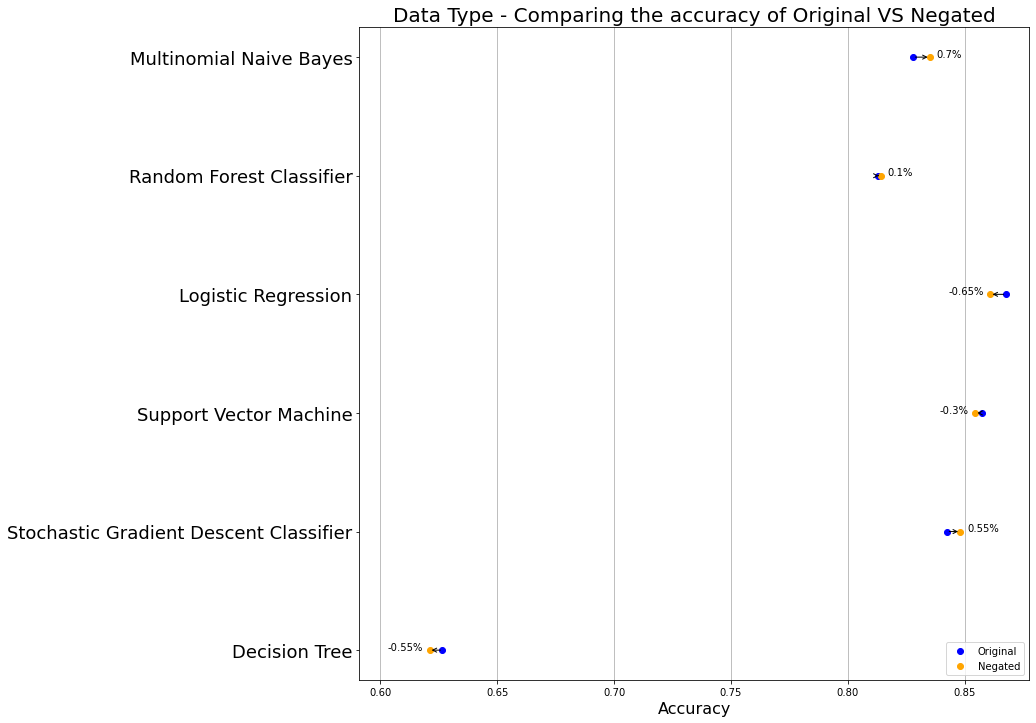

In [35]:
scf.compare_param_plot(exp_4_models, "Data Type", "Original", "Negated")

As with the effect using the lemmatised dataset had on the models performance, the effects here are also minimal with the change in performance for each model being less than 1%. Despite this small change, again the overall dirction across all the models seems to be in a negative direction with an average decrease of -0.025%.
Again the best model which was the Logistic Regression has had its accuracy decreased when using this negation handled dataset. While it is still the best performer of all the models, using the negated dataset has not proved favourable to it.

---

The result of these experiments with the different lemmatised and negation handled datasets have been that the original dataset is actually the best dataset to use. While some models see increases using the other datasets, the magnitude of these increases were not significant enough to outperform the Logistic Regression model when used on the original dataset. As a result it is not worth increasing the accuracy of these models at the detriment of a superior model as we are looking to find the absolute best model across all of these parameters. This currently seems to be the Logistic regression model.

# -----------------------------------------------------------------------------------------------------------------

# Experiments with adding a sentiment lexicon as a feature of these models

The final experiment we will do is looking at the effect that adding a sentiment lexicon feature to the data has on the models classification accuracy. When this parameter is turned on, 2 new column are added to the feature matrix. The first of these is a count of the number of positive lexicons in the document and the second is a count of the number of negative lexicons in the document. Unlike the other counts, these features are immune to being clipped at 1 as I felt this would not make sense. My thought process behind adding these features was that there should be a direct corrolation between the class label of a document and the number of words of that particular class that appear in the document.

Using the results from the previous experiments, for this experiment, we will configure the models to use the original dataset, a unigram feature set, and with the word counts clipped at 1. The below plot will then explore how the sentiment lexion feature effects the models over these configurations.

In [36]:
exp_5_models = all_models_results[(all_models_results["Clip Counts"] == True) & (all_models_results["Ngram"] == "Unigram") & (all_models_results["Data Type"] == "Original")]

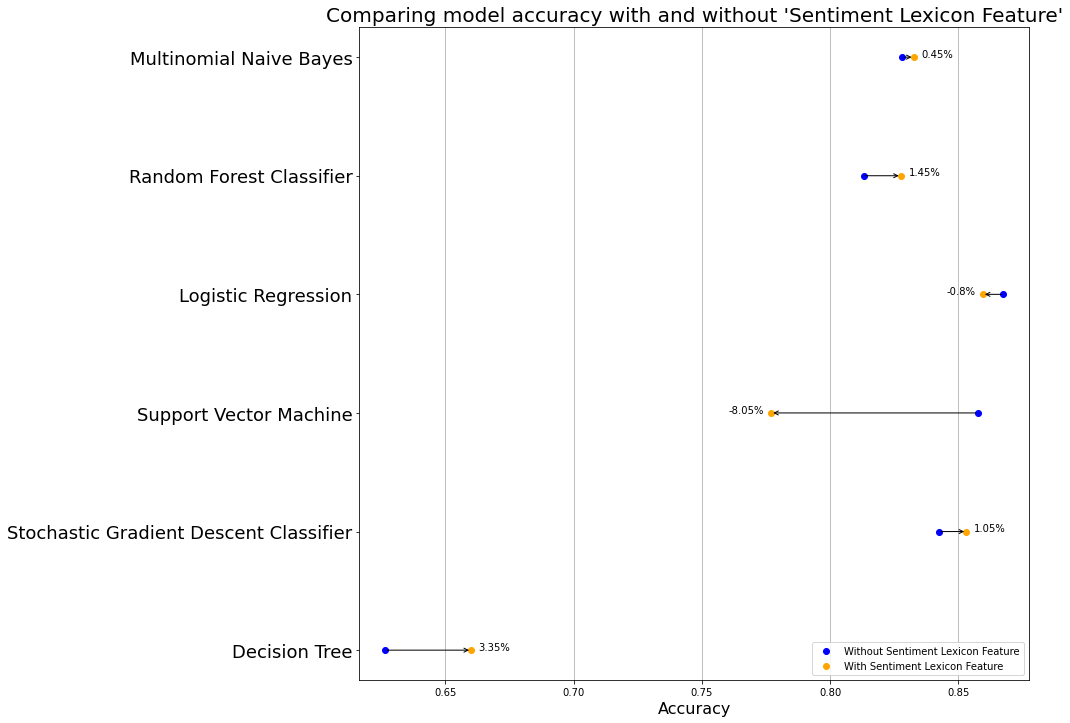

In [37]:
scf.compare_param_plot(exp_5_models, "Sentiment Lexicon Feature", False, True)

As I hypothesised, this parameter had a positive effect for the majority of the models with the accuracy scores for 4/6 models being improved. However, the problem with this parameter is that the two models that see a decrease in accuracy are the previously best performing models and as a result, the overall highest accuracy of all the models with this parameter configuration decreases. The most important model that we were keeping an eye on was the Logistic Regression model and the average accuracy score for this model dcrease by almost 1%.

The Support Vector Machine algorithm was particularly impacted by this change as it's average accuracy score was decreased by over 8%. We saw in previous experiments that when we clipped the word counts at 1 in the feature matrix, the accuracy for this model recieved a dramatic increase as it reacted positive to using binary features. It seems that since this sentiment lexicon feature has re-introduced non-binary features again, the accuracy score is retreating towards previous levels.

As a result of this decrease in accuracy for the previously best performing models, I have to conclude that not adding the sentiment lexicon features provides more value with regard to having a model that achieves the best 10-fold cross-validation accuracy on the classification task.

# -----------------------------------------------------------------------------------------------------------------

# Experiment summary

Summarising all of the above experiments, we saw that the Logistic Regression model has continuously performed the best of all of the learning algorithms experimented with. It recieved a boost in accuracy when we clipped the word counts which brought its accuracy up to 86.75%, a 5.1% increase on the baseline model. While we further experimented with other features and parameters, none of these ended up increasing the accuracy of this model further and also none of these increased the accuracy of any of the other models enough that they would beat this model's average accuracy. As a result, this ended up being the highest accuracy score that we recieved throughout this experimentation.

In conclusion, the best parameters were:

    Learning algorithm:                   Logistic Regression
    Ngram Size:                           Unigram
    Data Tye:                             Original Data
    Clip The Counts?:                     Yes
    Add a Sentiment Lexicon Feature?:     No
    
** If testing new data, these are the model parameters that should be used to evaluate against. This can be done by commenting out the other parameters in the above parameter lists and recompiling the list of models to be iterated through. This list of models should only have one item and the parameters of that item should reflect these above parameters.

# -----------------------------------------------------------------------------------------------------------------

# Look at all the models experimented with and rank them

On top of of the core models run for the above experiments, over the course of this assignment, I ran many more models combining different parameter configurations and recorded their average 10-fold cross-validaton accuracy scores. In total, the number of configured and evaluated models came to over *90* models with these models taking over *42 hours* to evaluate. To analyse the performance of each configered model, I will create a plot of their results. This will allow us to compare all of the models results and decide on the best one. This should validate our choice based on the above experiments.

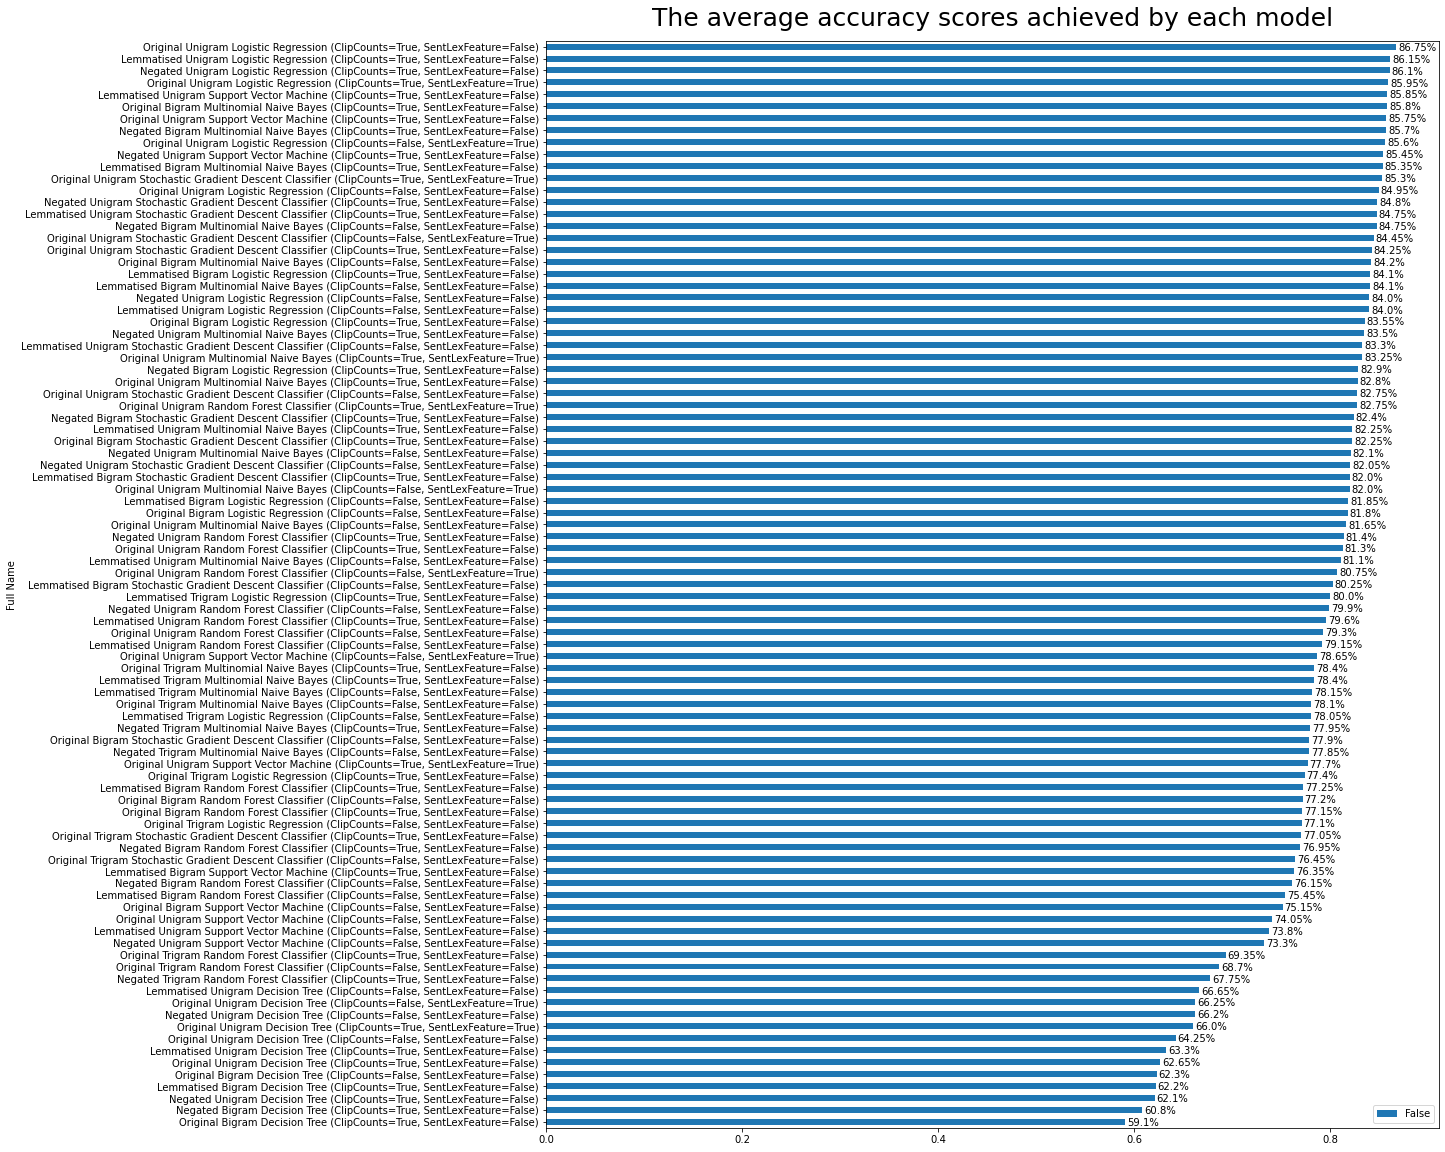

In [25]:
fig = all_models_results.sort_values(by="Avg Accuracy").plot.barh(x="Full Name", y="Avg Accuracy", figsize=(16, 20), label=False)
fig.set_title("The average accuracy scores achieved by each model", size=25, pad=15)

# Add the accuracy labels to the end of the bar plots
scf.add_value_labels(fig)

As you can see from this graph, the Logistic Regression model using the original dataset, unigram features, no sentiment lexicon fature, and with the counts clipped at 1 is the best model of all the combinations of models that I ran. As expected, this model was seen as the best model based on the experiments as well so this comes as no surprise that it is the best model of all the combinations.

The accuracy achieved by this model is 86.75% which is a 5.1% increase on the original Multinomial Naive Bayes baseline model.

In the end, only 2 changes were made to the original model, the first being that we use the Logistic Regression learning algorithm instead of Multinomial Naive Bayes, and the second being that we clip the word counts at 1 in the feature matrix.

This graph demonstrates the power of the Logistic Regression learning algorithm as you can see that the top 4 best performing models all used this learning algorithm and were only seperated by the dataset they were trained on and whether a sentiment lexicon feature was added to the feature matrix.

This graph also highlights how weak the Decision Tree algorithm is at classifying the sentiment of these documents. All of the 12 worst performing models used the Decision Tree learning algorithm.